# Tutorial 5: RJMCMC with Eryn

In the fifth tutorial, we will look at running Eryn when the underlying model is changing. This means we will be using Reversible-Jump MCMC, also referred to as trans-dimensional MCMC.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

## Task 1: How many Gaussian pulses?

In [2]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.moves import GaussianMove
from eryn.backends import HDFBackend
from chainconsumer import ChainConsumer, Chain

In [3]:
num     = 100 # the number of step for each dimension
lowlim  = -10 # Low limit on each axis
highlim = 10  # high limit on each axis
npulses = 10  # The # of injected pulses

dx = (highlim - lowlim)/num # Get the discritization

x, y    = np.mgrid[lowlim:highlim:dx, lowlim:highlim:dx] # Generate the grid

In [4]:
x

array([[-10. , -10. , -10. , ..., -10. , -10. , -10. ],
       [ -9.8,  -9.8,  -9.8, ...,  -9.8,  -9.8,  -9.8],
       [ -9.6,  -9.6,  -9.6, ...,  -9.6,  -9.6,  -9.6],
       ...,
       [  9.4,   9.4,   9.4, ...,   9.4,   9.4,   9.4],
       [  9.6,   9.6,   9.6, ...,   9.6,   9.6,   9.6],
       [  9.8,   9.8,   9.8, ...,   9.8,   9.8,   9.8]])

In [5]:
Amp    = np.random.uniform(.5, 1.5, size=(npulses)) # Draw an amplitude
spread = .2  # Keep their spread as fixed for simplicity.
sigma  = spread * np.diag(np.ones(2))

In [6]:
edges = 2 # Utility parameter, in order to avoid having signals at the border of our data set

# Draw the coordinates parameters
inj_coordinates = np.random.uniform(lowlim+edges, highlim-edges, size=(npulses, 2))

# Gather all parameters here
gauss_inj_params = [ [AA, xy[0], xy[1]] for AA, xy in zip(Amp, inj_coordinates)]

print(' * Parameters injected: \n\n', np.matrix(gauss_inj_params))

 * Parameters injected: 

 [[ 1.01242952 -6.37240543  6.56571384]
 [ 1.07027876  0.91274715 -1.95703256]
 [ 1.4975711  -6.69715213 -2.24446694]
 [ 0.98288662  5.5897961   6.84312336]
 [ 0.93167654 -6.94885294 -3.73434006]
 [ 0.97334178 -5.24902272  2.64735077]
 [ 1.24440507 -7.76544924  2.68045243]
 [ 1.13164689 -0.75695598 -1.35869047]
 [ 1.20028977 -2.16565281  4.96646073]
 [ 0.75073382  1.32694246 -1.43531204]]


In [7]:
# First we compute some constant terms of the Gaussian models (reminder: we have assumed a fixed spread for each pulse)
sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)
norm      = np.sqrt((2*np.pi)**2 * sigma_det)

def gaussian_flat(x, y, a, b, c):
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x;
    pos[:, :, 1] = y
    mu = [b, c]
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
    return a * np.exp(- fac / 2) / norm

def gaussian(X, Y, a, b, c):
    x = X[:,0]
    y = Y[0,:]
    # breakpoint()
    A = np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * sigma[0,0]))
    B = np.exp(-((y[None, :] - c[:, None]) ** 2) / (2 * sigma[1,1]))
    # breakpoint()
    C =  A[:, None, :] * B[:, :, None] # (np.expand_dims(A,axis=0) * np.expand_dims(np.transpose(B),axis=2))

    return a[:, None, None] * C / norm

def log_prob_fn(x1, X, Y, data, sig, inds=None, fill_inds=[], fill_values=None):

    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]
    n = num * num

    template  = np.sum(gaussian(X, Y, a, b, c), axis=0)

    llh = - 0.5 * ( np.sum(((template - data)) ** 2) )
    llh *= 1/sig**2
    llh += - n*np.log(sig) - .5 * n * np.log(2.*np.pi)
    return llh

In [8]:
sigma_noise = [[0.2]] # The nosie variance

noise = sigma_noise[0][0] * np.random.randn( num, num ) # Draw the random points for the noise

# Generate the data-set
injection = np.zeros( (num, num) )
for params in gauss_inj_params:
    injection += gaussian_flat(x, y, *params)
data = injection + noise

params = np.array(gauss_inj_params)

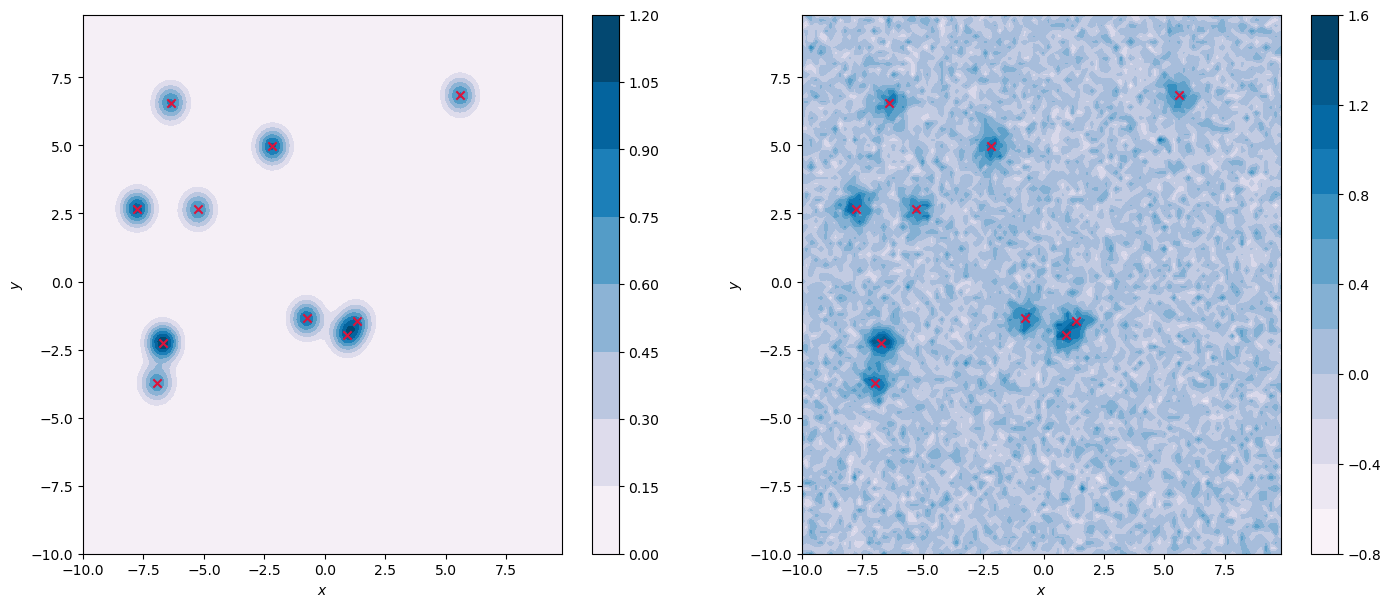

In [9]:
from matplotlib import cm

plt.figure(figsize=(17,7))
plt.subplot(121)
cf = plt.contourf(x, y, injection, 10, cmap=cm.PuBu)
plt.scatter(params[:,1], params[:,2], marker='x', color='#DC143C')
plt.colorbar(cf)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(122)
cf = plt.contourf(x, y, data, 10, cmap=cm.PuBu)
plt.scatter(params[:,1], params[:,2], marker='x', color='#DC143C')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(cf)
plt.show()


In [10]:
ndims        = {"pulse": 3}           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = {"pulse": 2*npulses}   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
branch_names = ["pulse"]

priors = {
    "pulse": {
        0: uniform_dist(0.5, 2.),
        1: uniform_dist(lowlim, highlim),
        2: uniform_dist(lowlim, highlim),
    }
}

In [11]:
ntemps = 10
nwalkers = 30

In [16]:
# nleaves max here is just for correct shape. Will turn off all but 1 per walker to start
coords = {
    name: ProbDistContainer(priors[name]).rvs(size=(ntemps, nwalkers, nleaves_max[name]))
    for name in branch_names
} 

inds_tmp = np.zeros(coords_tmp['pulse'].shape[:-1], dtype=bool)
inds_tmp[:, :, 0] = True

inds = {'pulse': inds_tmp}

In [17]:
factor = 0.01
cov    = {"pulse": np.diag(np.ones(3)) * factor}
moves = GaussianMove(cov)
betas = np.linspace(1.0, 0.0, ntemps)

In [26]:
ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data, sigma_det],
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min={"pulse": 0},
    update_iterations=1,
    plot_iterations=-1,
    moves=moves,
    rj_moves=True,
)

 # Number of samples per walker




In [19]:
state = State(coords, betas=betas, blobs=None, inds=inds)

In [27]:
nsteps = 5000
output = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)

100%|███████████████████████████████████████| 5000/5000 [49:13<00:00,  1.69it/s]


Parameter $x$ in chain An Example Contour is not constrained
Parameter $y$ in chain An Example Contour is not constrained


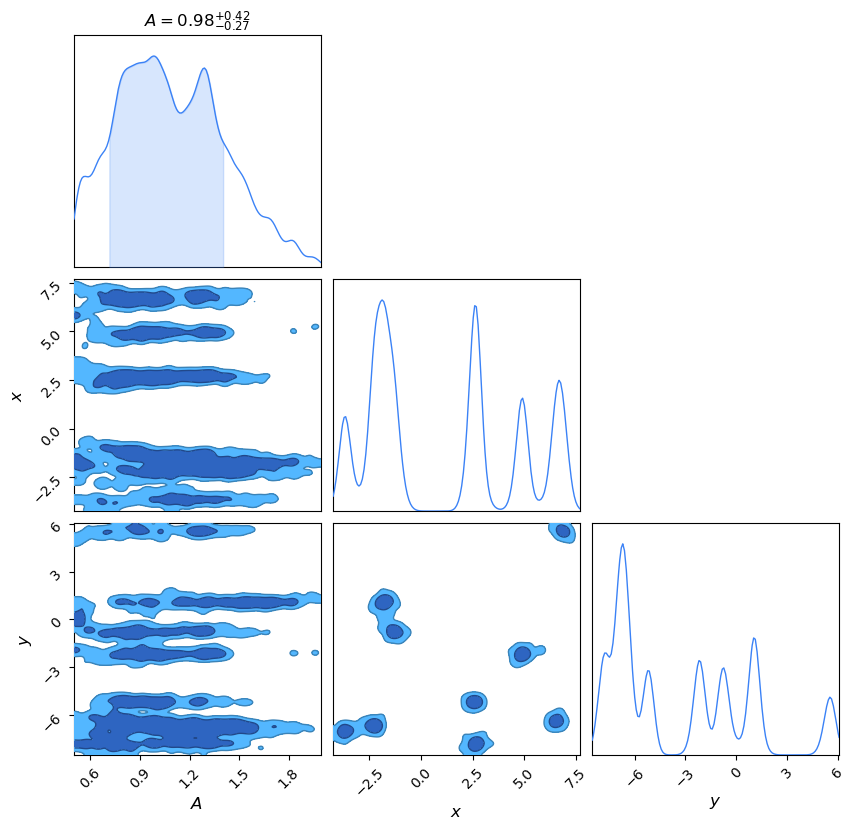

In [22]:
def get_clean_chain(coords, ndim, temp=0):
    """Simple utility function to extract the squeezed chains for all the parameters
    """
    naninds    = np.logical_not(np.isnan(coords[:, temp, :, :, 0].flatten()))
    samples_in = np.zeros((coords[:, temp, :, :, 0].flatten()[naninds].shape[0], ndim))  # init the chains to plot
    # get the samples to plot
    for d in range(ndim):
        givenparam = coords[:, temp, :, :, d].flatten()
        samples_in[:, d] = givenparam[
            np.logical_not(np.isnan(givenparam))
        ]  # Discard the NaNs, each time they change the shape of the samples_in
    return samples_in

pulse_parameters = ["$A$", r"$x$", r"$y$"]

samples_pulses = get_clean_chain(ensemble.backend.get_chain(thin=1)['pulse'], ndims['pulse'])
import pandas as pd
df = pd.DataFrame({key: val for key, val in zip(pulse_parameters, samples_pulses.T)})
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
fig = c.plotter.plot()

# for ii in range(npulses):
#     c.add_marker([gauss_inj_params[ii][0], gauss_inj_params[ii][1], gauss_inj_params[ii][2]], \
#     parameters=pulse_parameters, marker_style="x", \
#     marker_size=100, color='#DC143C')

# fig = c.plotter.plot(figsize=(8,8), legend=False);

<>:40: SyntaxWarning: invalid escape sequence '\#'
<>:40: SyntaxWarning: invalid escape sequence '\#'
/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_52080/4287252533.py:40: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("$\#$ of peaks in the data")


Text(0.5, 0, '$\\#$ of peaks in the data')

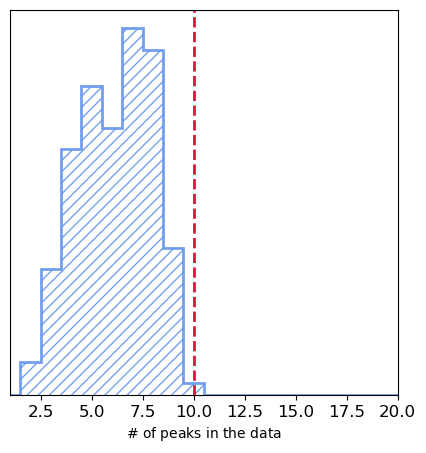

In [23]:
def get_clean_k_chains(backend, temp=0):
    """ A simple function to get the chains of model order k

    Args:
        backend: The Eryn backend

    Returns:
        k_chain: the chains of the k order
    """
    inds = backend.get_value("inds")  # Get the leaves out
    branches = {name: np.sum(inds[name], axis=-1, dtype=int) for name in inds}
    for (branch) in (branches):  # Get the total number of components/branches per temperature
        if branch == list(branches.keys())[0]:
            k_chain = branches[branch][:, temp].flatten()
        else:
            k_chain += branches[branch][:, temp].flatten()
    return k_chain

gauss_k_chain_baseline = get_clean_k_chains(ensemble.backend)

bns = (np.arange(1, nleaves_max['pulse'] + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch

fig = plt.figure(figsize=(5, 5))
plt.hist(
        gauss_k_chain_baseline-1,
        bins=bns,
        color='#6495ed',
        alpha=0.9,
        lw=2,
        histtype='step',
        density=True,
        hatch='///'
        )

plt.axvline(x=int(npulses), linestyle='--', lw=2, color='#DC143C')

plt.xticks(fontsize=12)
plt.yticks([])
plt.xlim(1, 20)
plt.xlabel("$\#$ of peaks in the data")

## Task 2: Model selection with RJMCMC

In [67]:
from scipy.stats import cauchy
def gaussian_pulse(x, a, b):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * 1.0 ** 2))
    return f_x

def cauchy_pulse(x, a, b):
    f_x = a * cauchy.pdf(x - b)
    return f_x

def log_like_fn(params, t, data, sigma, which_template):

    pulse_gen = gaussian_pulse if which_template == "gauss" else cauchy_pulse
    template = pulse_gen(t, *params)

    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll

def log_like_wrap(params, *args):
    assert len(params) == 2
    if params[0] is not None:
        assert params[1] is None
        # gauss will be first set of params
        args += ("gauss",)
        ll = log_like_fn(params[0][0], *args)

    else:
        assert params[0] is None
        # gauss will be first set of params
        args += ("cauchy",)
        ll = log_like_fn(params[1][0], *args)

    return ll

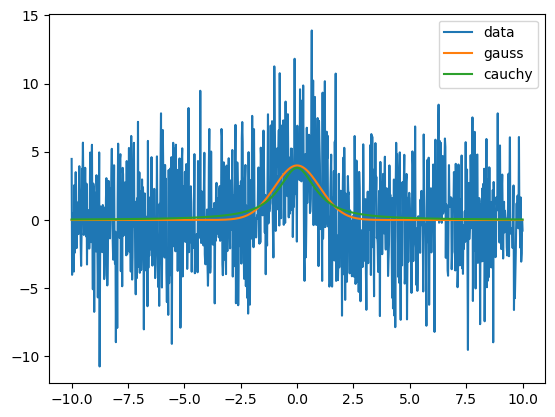

In [116]:
t_vals = np.linspace(-10.0, 10.0, 1000)
sigma = 3.5
amp_true = 4.0
mean_true = 0.0
true_data = gaussian_pulse(t_vals, amp_true, mean_true)
data = true_data + np.random.randn(*t_vals.shape) * sigma
cauchy_data = cauchy_pulse(t_vals, amp_true * 3, mean_true)
plt.plot(t_vals, data, label="data")
plt.plot(t_vals, true_data, label="gauss")
plt.plot(t_vals, cauchy_data, label="cauchy")
plt.legend()
# plt.plot(x_vals, np.exp(log_like_fn()))
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

In [117]:
priors = {}
start_point = {}
burn = 1000

is_gauss = np.random.randint(0, 2, size=(ntemps, nwalkers, 1), dtype=bool)

for name in ["gauss", "cauchy"]: 
    priors[name] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
})  

    start_point[name] = priors[name].rvs(size=(ntemps, nwalkers, 1))

    # setup so that every state has either "Gauss" or "Cauchy"
    inds[name] = is_gauss if name == "gauss" else ~is_gauss    

assert np.all(inds["gauss"].astype(int) + inds["cauchy"].astype(int) == 1)
start_state = State(start_point, inds)

ndims = {"gauss": 2, "cauchy": 2}
nleaves_max = {"gauss": 1, "cauchy": 1}
nleaves_min = {"gauss": 0, "cauchy": 0}

factor = 0.01
cov    = {"gauss": np.diag(np.ones(2)) * factor, "cauchy": np.diag(np.ones(2)) * factor}
moves = GaussianMove(cov)

In [118]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    log_like_wrap,
    priors,
    nbranches=2,
    branch_names=["gauss", "cauchy"],  # order determines order of parameter sets in Likelihood
    tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf),
    args=(t_vals, data, sigma),
    rj_moves=True,
    moves=moves,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min
)

In [119]:
nteps = 500
sampler.run_mcmc(start_state, nsteps, progress=True, burn=100)

100%|███████████████████████████████████████| 5000/5000 [05:56<00:00, 14.04it/s]


In [120]:
nleaves = sampler.get_nleaves()

In [121]:
nleaves["gauss"][-1][0], nleaves["cauchy"][-1][0]

(array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))

In [115]:
nleaves["gauss"][:, 0].sum() / np.prod(nleaves["gauss"][:, 0].shape)

0.9991